# "Neural Network Digit Classifier"

> "Using fast.ai and Pytorch's modules, building a Neural Network digit classifier using MNIST data set"

- toc: true
- branch: master
- comments : False
- author : Eric Vincent
- categories : [fastpages, jupyter]

## Neural network image classifier using fast.ai and Pytorch modules
 1. Install required modules and get the training and validation data from MNIST.

In [1]:
#collapse_output
pip install fastbook

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 927.7 kB/s eta 0:00:00a 0:00:01
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.3.0
    Uninstalling typing_extensions-4.3.0:
      Successfully uninstalled typing_extensions-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
tensorflow 2.6.4 requires h5py~=3.1.0, but you have h5py 3.7.0 which is incompatible.
tensorflow 2.6.4 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.6.4 requires tensorboard<2.7,>=2.6.0, but you have tensorboard 2.10.0 which is incompatible.
tensorflow 2.6.4 requires typing-extensions<3.11,>=3.7, but you have typing-extensions 4.1.1 which is incompatible.
tensorflow-transform 1.9.0 requires tensorflow!=2

In [2]:
import fastbook
fastbook.setup_book()

In [3]:
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

In [4]:
path = untar_data(URLs.MNIST_SAMPLE)
Path.BASE_PATH = path

In [5]:
# Check folder for labels
path.ls()

(#3) [Path('valid'),Path('labels.csv'),Path('train')]

In [6]:
(path/'train').ls()


(#2) [Path('train/7'),Path('train/3')]

In [7]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

In [8]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

In [9]:
# Check the array of the digit '3'
array(im3)[4:10,4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [10]:
#collapse_output
tensor(im3)[4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

In [11]:
# Use of pd dataframe to represent the the digit with a gradient
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[:])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0,0,0,0,0,0,0


In [12]:
# Create a tesor containing all of the images in both training folders for both 7s and 3s
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors),len(seven_tensors)

(6131, 6265)

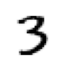

In [13]:
#collapse_output
# Check one of the images created
show_image(three_tensors[1]);

In [14]:
# For every pixel position, compute the average over all of the images of the intensity of that pixel. Combine all of the images in this list into a single three-dimensional tensor (rank-3 tensor)
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

In [15]:
# check the tensors rank
stacked_threes.ndim

3

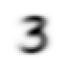

In [16]:
# Given that or first dimension contains all of the images, we can compute the mean of all image tensors, i.e. compute the average of that pixel over all images.
mean3 = stacked_threes.mean(0)
show_image(mean3);

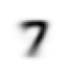

In [17]:
mean7 = stacked_sevens.mean(0)
show_image(mean7);

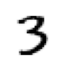

In [18]:
#collapse_output
# Check a random image and see how far its distance is from the ideal three
a_3 = stacked_threes[1]
show_image(a_3);

In [19]:
# Compute L1 norm (mean of the absolute value of dfferences) and L2 norm (RMSE)
dist_3_abs = (a_3 - mean3).abs().mean()
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()
dist_3_abs,dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [20]:
dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()
dist_7_abs,dist_7_sqr

(tensor(0.1586), tensor(0.3021))

In [21]:
# compute the same loss functions with Pytorch : torch.nn.functional (import as F)
F.l1_loss(a_3.float(),mean7), F.mse_loss(a_3,mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

## Compute Metrics using Broadcasting

Start by getting validation labels from the MNIST dataset for both digits

In [22]:
valid_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape,valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [23]:
# Create a basic function that determines the distance between an image and our ideal 3 digit (Mean absolute error). The mean is computed on the horizontal and vertical axes i.e. -1 & -2
def mnist_distance(a,b): 
    return (a-b).abs().mean((-1,-2))
mnist_distance(a_3, mean3)

tensor(0.1114)

In [24]:
# calculate the distance for all of the 3s in the validation set compared to the valid_3_tens object - i.e. Pytorch will use broadcasting given that the tensors are of different rank
valid_3_dist = mnist_distance(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1270, 0.1632, 0.1676,  ..., 0.1228, 0.1210, 0.1287]),
 torch.Size([1010]))

In [25]:
# Create a function that to determine if the digit is a 3
def is_3(x): return mnist_distance(x,mean3) < mnist_distance(x,mean7)

In [26]:
# Test it out
is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

In [27]:
# Test our function on the whole validation set of 3s :
is_3(valid_3_tens)

tensor([ True, False, False,  ...,  True,  True, False])

In [28]:
# Calculate the accuracy for each of the 3s and 7s by taking the average of that function for all 3s and its inverse for all 7s
accuracy_3s =      is_3(valid_3_tens).float() .mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()

accuracy_3s,accuracy_7s,(accuracy_3s+accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

# Use Stochastic Gradient Descent to optimize our prediction model
1. Initialize the weights.
2. For each image, use these weights to predict whether it appears to be a 3 or a 7.
3. Based on these predictions, calculate how good the model is (its loss).
4. Calculate the gradient, which measures for each weight, how changing that weight would change the loss
5. Step (that is, change) all the weights based on that calculation.
6. Go back to the step 2, and repeat the process.
7. Iterate until we stop the training process 

In [29]:
# Simple quadractic function that will be used for SGD
def f(x): return x**2

In [30]:
# Get a tensor which will requre gradients
xt = tensor(3.).requires_grad_()

In [31]:
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

In [32]:
# Get Pytorch to calculate the gradients:
yt.backward()

In [33]:
xt.grad

tensor(6.)

In [34]:
# Repeat the steps but with a vector argument 
xt = tensor([3.,4.,10.]).requires_grad_()
xt

# Add sum to the quadratic function so it can take a vector (rank-1 tensor) and return a scalar (rank-0 tensor)
def f(x): return (x**2).sum()

yt = f(xt)
yt

tensor(125., grad_fn=<SumBackward0>)

In [35]:
yt.backward()
xt.grad

tensor([ 6.,  8., 20.])

In [36]:
# Implement stepping with a learning rate
 # w -= gradient(w) * lr


In [37]:
# Loss function that will be used in our parameters, and quadratic function that will be used to measure the inputs vs the functions parameters
def mse(preds, targets): return ((preds-targets)**2).mean()

def f(t, params):
    a,b,c = params
    return a*(t**2) + (b*t) + c

In [38]:
def apply_step(params, prn=True):
    preds = f(time, params)
    loss = mse(preds, speed)
    loss.backward()
    params.data -= lr * params.grad.data
    params.grad = None
    if prn: print(loss.item())
    return preds


In [39]:
# Implementing th MNIST Loss function
# start by by concatenating all of our images (independant x variable) into a single tensor and change them from a list of matrices (rank-3 tensor) to a list of vectors (a rank-2 tensor) -- using Pytorch's
# view method.

train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)


In [40]:
# Create labels for each image
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_x.shape,train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [41]:
# zip together our dataset to crate a tuple
dset = list(zip(train_x,train_y))
x,y = dset[0]
x.shape,y

(torch.Size([784]), tensor([1]))

In [42]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

In [43]:
# Initialize random weights for every pixel
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

In [44]:
weights = init_params((28*28,1))

In [45]:
bias = init_params(1)

In [46]:
# Calculate a prediction for one image
(train_x[0]*weights.T).sum() + bias

tensor([-6.2330], grad_fn=<AddBackward0>)

In [47]:
def linear1(xb): return xb@weights + bias
preds = linear1(train_x)
preds

tensor([[ -6.2330],
        [-10.6388],
        [-20.8865],
        ...,
        [-15.9176],
        [ -1.6866],
        [-11.3568]], grad_fn=<AddBackward0>)

In [48]:
corrects = (preds>0.0).float() == train_y
corrects

tensor([[False],
        [False],
        [False],
        ...,
        [ True],
        [ True],
        [ True]])

In [49]:
corrects.float().mean().item()

0.5379961133003235

In [50]:
with torch.no_grad(): weights[0] *= 1.0001

In [51]:
preds = linear1(train_x)
((preds>0.0).float() == train_y).float().mean().item()

0.5379961133003235

In [52]:
# implementing a loss function
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

In [55]:
# basic data set for our dataloader
ds = L(enumerate(string.ascii_lowercase))
ds

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j')...]

In [54]:
# Putting the final model toogether
# Re-initialize parameters
weights = init_params((28*28,1))
bias = init_params(1)

In [56]:
# create a DataLoader from a dataset
dl = DataLoader(dset, batch_size=256)
xb,yb = first(dl)
xb.shape,yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [62]:
valid_dl = DataLoader(valid_dset, batch_size=256)

In [63]:
# create a mini batch for testing
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [65]:
preds = linear1(batch)
preds

tensor([[14.0882],
        [13.9915],
        [16.0442],
        [17.7304]], grad_fn=<AddBackward0>)

In [66]:
loss = mnist_loss(preds, train_y[:4])
loss

tensor(4.1723e-07, grad_fn=<MeanBackward0>)

In [67]:
# calculate the gradients
loss.backward()
weights.grad.shape,weights.grad.mean(),bias.grad

(torch.Size([784, 1]), tensor(-5.9512e-08), tensor([-4.1723e-07]))

In [68]:
# create a function to calculate the gradients
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [69]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-1.1902e-07), tensor([-8.3446e-07]))

In [70]:
# call it again
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-1.7854e-07), tensor([-1.2517e-06]))

In [71]:
# set the current gradients to 0 first (i.e. sets all the elements of the tensor bias to 0)
weights.grad.zero_()
bias.grad.zero_();

In [72]:
# update the weights and biases on the gradient and learning rate
def train_epoch(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

In [73]:
# check predictions for a couple of images
(preds>0.0).float() == train_y[:4]

tensor([[True],
        [True],
        [True],
        [True]])

In [74]:
# calculate our validation accuracy
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

In [75]:
batch_accuracy(linear1(batch), train_y[:4])

tensor(1.)

In [76]:
# put the batches together
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [77]:
validate_epoch(linear1)

0.5748

In [78]:
# train again for an epoch and see if the accuracy improves
lr = 1.
params = weights,bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.7251

In [79]:
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

0.8569 0.9096 0.9296 0.9399 0.9467 0.9545 0.9569 0.9628 0.9647 0.9662 0.9672 0.9681 0.9725 0.9725 0.9725 0.973 0.9735 0.974 0.974 0.975 

# Creating an optimizer
1. replace linear1 function with Pytorch's nn.lineat module
   reminder : nn.linear accomplishes the same thing as init_params and linear together - it contains both the weights and biases in a single class

In [80]:
linear_model = nn.Linear(28*28,1)

In [81]:
# check out what parameters this module has that can be trained :
w,b = linear_model.parameters()
w.shape,b.shape

(torch.Size([1, 784]), torch.Size([1]))

In [82]:
# create the optimizer Class

class BasicOptim:
    def __init__(self,params,lr): self.params,self.lr = list(params),lr

    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None


In [83]:
# create the optimizer 
opt = BasicOptim(linear_model.parameters(), lr)

In [84]:
# the training loop can now be simplified to :
def train_epoch(model):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

In [85]:
# validation function is unchanged 
validate_epoch(linear_model)

0.6381

In [86]:
# put the training loop into a function
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

In [87]:
train_model(linear_model, 20)

0.4932 0.7724 0.8559 0.916 0.935 0.9472 0.9579 0.9628 0.9658 0.9677 0.9697 0.9716 0.9741 0.975 0.976 0.9765 0.9775 0.978 0.978 0.978 

In [88]:
# same results as previously
# fast ai SGD class is the same as our BasicOptim class, therefore:
linear_model = nn.Linear(28*28,1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.4932 0.831 0.8398 0.9116 0.934 0.9477 0.956 0.9623 0.9658 0.9667 0.9697 0.9726 0.9741 0.975 0.9755 0.9765 0.9775 0.9785 0.9785 0.9785 

In [90]:
# before creating the learner we need to create a dataloaders by passing it our training and validation:
dls = DataLoaders(dl, valid_dl)

In [91]:
# to create a learner we will need to pass it all of our elements : a DataLoaders class, the model, optimization function (which will be passed the parameters), the loss function,
learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [92]:
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.637040,0.503638,0.495584,00:00
1,0.596475,0.159199,0.878312,00:00
2,0.216541,0.197214,0.819431,00:00
3,0.093282,0.111199,0.908243,00:00
4,0.047910,0.080145,0.931305,00:00
5,0.030276,0.063814,0.946025,00:00
6,0.023095,0.053701,0.955348,00:00
7,0.019960,0.046993,0.961727,00:00
8,0.018413,0.042308,0.965162,00:00
9,0.017511,0.038881,0.967125,00:00


# Adding Nonlinearity

In [93]:
# example of a simple neural network, incoporating ReLU

def simple_net(xb): 
    res = xb@w1 + b1
    res = res.max(tensor(0.0))
    res = res@w2 + b2
    return res


In [ ]:
w1 = init_params((28*28,30))
b1 = init_params(30)
w2 = init_params((30,1))
b2 = init_params(1)

In [94]:
# take advantage of Pytorch's library 
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

In [95]:
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [96]:
learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.385122,0.388649,0.520118,00:00
1,0.170687,0.256767,0.771835,00:00
2,0.090929,0.123868,0.908734,00:00
3,0.057405,0.081251,0.938665,00:00
4,0.042229,0.062670,0.952895,00:00
5,0.034708,0.052418,0.963690,00:00
6,0.030526,0.046020,0.965653,00:00
7,0.027888,0.041687,0.966634,00:00
8,0.026028,0.038563,0.968106,00:00
9,0.024608,0.036192,0.968597,00:00


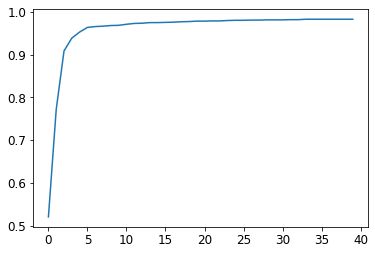

In [97]:
# plot the accuracy over training :
plt.plot(L(learn.recorder.values).itemgot(2));

In [98]:
# final accuracy
learn.recorder.values[-1][2]

0.982826292514801

In [99]:
# train a 18-layer model using the same approach
dls = ImageDataLoaders.from_folder(path)
learn = vision_learner(dls, resnet18, pretrained=False,
                    loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.074170,0.031738,0.994112,00:23
